# ● Libraries

In [2]:
import tqdm
import time
import numpy as np
import cv2
from sklearn.metrics import (roc_curve, auc, accuracy_score, f1_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from dataio import *
from preprocess import *
from segment import *
from colorfeatures import *
from classify import *
from feature_extraction import *

In [84]:
# Load Prior Session Variables
import dill
#dill.dump_session('predict_env.db')
#dill.load_session('predict_env.db')

# ● Dataset

In [3]:
train_data = sortData('../data/train')                 # Load Training Set

Number of LES Images: 2400
Number of NV Images: 2400


In [4]:
val_data   = sortData('../data/val')                   # Load Validation Set

Number of LES Images: 600
Number of NV Images: 600


In [3]:
test_data   = sortData(r'C:\Users\30694\Downloads\Melanoma_DeepLearning\siim-isic-melanoma-classification\jpeg\test', mode='test')     # Load Testing Set

Number of Test Images: 10982


# ● Feature Extraction: (Train+Val) Datasets

In [6]:
train_features_les = [] 
train_features_nv  = []

counter      = 0
start        = 0
stop         = len(train_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = plt.imread(train_data[index]['image'])
    scan_id  = train_data[index]['id']
    label    = train_data[index]['label']
        
    # External Preprocessing (Discontinued)
    # hr,_     = occlusion_removal(image)       # Occlusion Removal
    # cl       = clahe_LAB(hr)                  # CLAHE Preprocessing
    
    # Segmentation (Discontinued)
    # mask     = segment_lesion(image, mode="active_contours")
    # mask     = (plt.imread(train_data[index]['mask'])).astype(bool)
        
    # Feature Extraction
    features = extract_features(image)
    features = np.expand_dims(np.asarray(features),axis=0)
    
    # Pass to Feature Vectors
    if (label==1):                           # LES Features
        if (len(train_features_les)==0):
            train_features_les = features
        else:
            train_features_les = np.concatenate((train_features_les,features),axis=0)
    if (label==0):                           # NV Features
        if (len(train_features_nv)==0):
            train_features_nv = features
        else:
            train_features_nv = np.concatenate((train_features_nv,features),axis=0)
    counter = counter + 1

print("Features Extraction (Training Set) Complete: "+str(counter))

100%|████████████████████████████████████████████████████████████████████████████| 4800/4800 [2:44:30<00:00,  2.06s/it]


Features Extraction (Training Set) Complete: 4800


In [7]:
val_features_les = [] 
val_features_nv  = []

counter      = 0
start        = 0
stop         = len(val_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = plt.imread(val_data[index]['image'])
    scan_id  = val_data[index]['id']
    label    = val_data[index]['label']
    
    # External Preprocessing (Discontinued)
    # hr,_     = occlusion_removal(image)       # Occlusion Removal
    # cl       = clahe_LAB(hr)                  # CLAHE Preprocessing
    
    # Segmentation (Discontinued)
    # mask     = segment_lesion(cl, mode="active_contours")   
    # mask     = (plt.imread(train_data[index]['mask'])).astype(bool)
    
    # Feature Extraction
    features = extract_features(image)
    features = np.expand_dims(np.asarray(features),axis=0)
    
    # Pass to Feature Vectors
    if (label==1):                           # LES Features
        if (len(val_features_les)==0):
            val_features_les = features
        else:
            val_features_les = np.concatenate((val_features_les,features),axis=0)
    if (label==0):                           # NV Features
        if (len(val_features_nv)==0):
            val_features_nv = features
        else:
            val_features_nv = np.concatenate((val_features_nv,features),axis=0)
    counter = counter + 1

print("Features Extraction (Validation Set) Complete: "+str(counter))

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [37:37<00:00,  1.88s/it]


Features Extraction (Validation Set) Complete: 1200


# ● Feature Extraction: Test Dataset

In [4]:
test_features = [] 

counter      = 0
start        = 0
stop         = len(test_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = plt.imread(test_data[index]['image'])
    scan_id  = test_data[index]['id']
    
    # External Preprocessing (Discontinued)
    # hr,_     = occlusion_removal(image)       # Occlusion Removal
    # cl       = clahe_LAB(hr)                  # CLAHE Preprocessing
    
    # Segmentation (Discontinued)
    # mask     = segment_lesion(cl, mode="active_contours")   
    # mask     = (plt.imread(train_data[index]['mask'])).astype(bool)
    
    # Feature Extraction
    features = extract_features(image)
    features = np.expand_dims(np.asarray(features),axis=0)
    
    # Pass to Feature Vectors
    if (len(test_features)==0):
        test_features = features
        test_ids      = scan_id.replace("../data/test\\", "")
    else:
        test_features = np.concatenate((test_features,features),axis=0)
        test_ids      = np.append(test_ids,scan_id)
    
    counter = counter + 1

print("Features Extraction (Testing Set) Complete: "+str(counter))

100%|██████████████████████████████████████████████████████████████████████████████| 1015/1015 [33:18<00:00,  1.97s/it]


Features Extraction (Testing Set) Complete: 1015


# ● Merge, Shuffle, Concatenate, Normalize

In [4]:
# Combine Train/Val Feature Vectors
full_features_les = np.zeros(shape=(train_features_les.shape[0]+val_features_les.shape[0],train_features_les.shape[1]))
full_features_nv  = np.zeros(shape=(train_features_nv.shape[0]+val_features_nv.shape[0],train_features_nv.shape[1]))

full_features_les[:train_features_les.shape[0],:] = train_features_les
full_features_les[train_features_les.shape[0]:,:] = val_features_les
full_features_nv[:train_features_nv.shape[0],:]   = train_features_nv
full_features_nv[train_features_nv.shape[0]:,:]   = val_features_nv

# Intra-Class Shuffle
rnd                = np.random.RandomState(8)
shuffled_indices   = rnd.permutation(np.arange(full_features_nv.shape[0]))
full_features_les  = full_features_les[shuffled_indices]
full_features_nv   = full_features_nv[shuffled_indices]

In [74]:
# Inter-Class Shuffle (Not Mandatory), Concatenation, Normalization
# "Unlike the backpropagation learning algorithm for artificial neural networks, a given SVM will always deterministically
#  converge to the same solution for a given data set, regardless of the initial conditions. [Campbell and Cristianini, 1999]"

X, Y               = concat_and_shuffled(class0=full_features_nv, class1=full_features_les, shuffled=False)

# Scaling Test Features Blindly by Those Determined During Training/Validation 
Z                  = (test_features-np.mean(X,axis=0))/np.std(X,axis=0)
X                  = (X-np.mean(X,axis=0))/np.std(X,axis=0)

# ● Classifier: Training

In [75]:
SVMclassifier = svm.SVC(C=10, kernel='rbf', gamma='scale', probability=True, class_weight='balanced', random_state=8)
SVMclassifier.fit(X,Y)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=8, shrinking=True, tol=0.001,
    verbose=False)

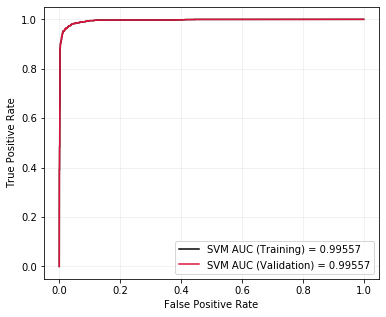

In [76]:
# Redundancy Check (Training=Validation=High)
ROC(X,Y,X,Y,SVMclassifier)

# ● Classifier: Inference

In [77]:
# Redundancy Check (Verify Order of Predictions)
expecting_label_0 = SVMclassifier.predict(X[:3000,:])
expecting_label_1 = SVMclassifier.predict(X[3000:,:])

# First 3000 samples are Class 0: NV; Second 3000 samples are Class 1: LES
# Inference Accuracy should be High, since we're predicting on the Training Set
print("Expecting 0: " + str(expecting_label_0.mean()))
print("Expecting 1: " + str(expecting_label_1.mean()))

Expecting 0: 0.03166666666666667
Expecting 1: 0.9733333333333334


In [100]:
inference_labels = SVMclassifier.predict(Z)
inference_probs  = SVMclassifier.predict_proba(Z)
inference_probs  = np.maximum(inference_probs[:,0],inference_probs[:,1])
inference_ids    = test_ids

# Predicting More NV or LES?
inference_labels.mean()

0.35763546798029555

In [6]:
test_data[0]


{'id': 'ISIC_0052060',
 'image': 'C:\\Users\\30694\\Downloads\\Melanoma_DeepLearning\\siim-isic-melanoma-classification\\jpeg\\test\\ISIC_0052060.jpg'}

In [8]:
# load the model
import pickle
model = pickle.load(open(r"C:\Users\30694\Melanoma-Classification\models\model.pkl", "rb"))

In [117]:

demo = plt.imread(r"C:\Users\30694\Downloads\Melanoma_DeepLearning\siim-isic-melanoma-classification\jpeg\val_images\malignant\ISIC_7897925.jpg")

In [122]:
def extract_features(image,mask=None):  
 
    # Color Spaces: I/O ------------------------------------------------------------------------------------------------------------------------------------------------------
    img_RGB               = image
    img_GL                = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)
    
    img_HSV               = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
    img_LAB               = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2Lab)
    img_YCrCb             = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)
    img_luv               = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2Luv)
    circa_mask            = create_circular_mask(image.shape[0], image.shape[1], radius = 300).astype(bool)
    
    masked_lesion_GL      = np.ma.array(np.multiply(img_GL,    circa_mask)  ,mask=~circa_mask)
    masked_lesion_RGB     = np.ma.array(np.multiply(img_RGB,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    masked_lesion_HSV     = np.ma.array(np.multiply(img_HSV,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    masked_lesion_LAB     = np.ma.array(np.multiply(img_LAB,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    masked_lesion_YCrCb   = np.ma.array(np.multiply(img_YCrCb, np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    masked_lesion_luv     = np.ma.array(np.multiply(img_luv,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    
    
    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    
    # Color Constancy Spaces: I/O ---------------------------------------------------------------------------------------------------------------------------------------------

    img_ccRGB,_           = color_constant(image)
    img_ccGL              = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)
    img_ccHSV             = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
    img_ccLAB             = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2Lab)
    img_ccYCrCb           = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)
    img_ccluv             = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2Luv)
    
    masked_lesion_ccGL    = np.ma.array(np.multiply(img_ccGL,    circa_mask)  ,mask=~circa_mask)
    masked_lesion_ccRGB   = np.ma.array(np.multiply(img_ccRGB,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    masked_lesion_ccHSV   = np.ma.array(np.multiply(img_ccHSV,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    masked_lesion_ccLAB   = np.ma.array(np.multiply(img_ccLAB,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    masked_lesion_ccYCrCb = np.ma.array(np.multiply(img_ccYCrCb, np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    masked_lesion_ccluv   = np.ma.array(np.multiply(img_ccluv,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    
    
    img_mxRGB             = (correct_image(image, grey_edge(image, njet=0, mink_norm=-1, sigma=0))*255).astype(np.uint8)
    img_mxGL              = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)
    img_mxHSV             = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
    img_mxLAB             = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2Lab)
    img_mxYCrCb           = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)
    img_mxluv             = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2Luv)
    
    masked_lesion_mxGL    = np.ma.array(np.multiply(img_mxGL,    circa_mask)  ,mask=~circa_mask)
    masked_lesion_mxRGB   = np.ma.array(np.multiply(img_mxRGB,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    masked_lesion_mxHSV   = np.ma.array(np.multiply(img_mxHSV,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    masked_lesion_mxLAB   = np.ma.array(np.multiply(img_mxLAB,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    masked_lesion_mxYCrCb = np.ma.array(np.multiply(img_mxYCrCb, np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    masked_lesion_mxluv   = np.ma.array(np.multiply(img_mxluv,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    
    
    # Color Moments ----------------------------------------------------------------------------------------------------------------------------------------------------------------
    mean_R, std_R, skew_R, kurt_R, mean_G,  std_G,  skew_G,  kurt_G,  mean_B,  std_B,  skew_B,  kurt_B   = color_moments(masked_lesion_RGB,     channel=3)
    mean_H, std_H, skew_H, kurt_H, mean_S,  std_S,  skew_S,  kurt_S,  mean_V,  std_V,  skew_V,  kurt_V   = color_moments(masked_lesion_HSV,     channel=3)
    mean_L, std_L, skew_L, kurt_L, mean_A,  std_A,  skew_A,  kurt_A,  mean_b,  std_b,  skew_b,  kurt_b   = color_moments(masked_lesion_LAB,     channel=3)
    mean_Y, std_Y, skew_Y, kurt_Y, mean_Cr, std_Cr, skew_Cr, kurt_Cr, mean_Cb, std_Cb, skew_Cb, kurt_Cb  = color_moments(masked_lesion_YCrCb,   channel=3)
    mean_l, std_l, skew_l, kurt_l, mean_u,  std_u,  skew_u,  kurt_u,  mean_v,  std_v,  skew_v,  kurt_v   = color_moments(masked_lesion_luv,     channel=3)
    
    mean_ccR, std_ccR, skew_ccR, kurt_ccR, mean_ccG,  std_ccG,  skew_ccG,  kurt_ccG,  mean_ccB,  std_ccB,  skew_ccB,  kurt_ccB   = color_moments(masked_lesion_ccRGB,   channel=3)
    mean_ccH, std_ccH, skew_ccH, kurt_ccH, mean_ccS,  std_ccS,  skew_ccS,  kurt_ccS,  mean_ccV,  std_ccV,  skew_ccV,  kurt_ccV   = color_moments(masked_lesion_ccHSV,   channel=3)
    mean_ccL, std_ccL, skew_ccL, kurt_ccL, mean_ccA,  std_ccA,  skew_ccA,  kurt_ccA,  mean_ccb,  std_ccb,  skew_ccb,  kurt_ccb   = color_moments(masked_lesion_ccLAB,   channel=3)
    mean_ccY, std_ccY, skew_ccY, kurt_ccY, mean_ccCr, std_ccCr, skew_ccCr, kurt_ccCr, mean_ccCb, std_ccCb, skew_ccCb, kurt_ccCb  = color_moments(masked_lesion_ccYCrCb, channel=3)
    mean_ccl, std_ccl, skew_ccl, kurt_ccl, mean_ccu,  std_ccu,  skew_ccu,  kurt_ccu,  mean_ccv,  std_ccv,  skew_ccv,  kurt_ccv   = color_moments(masked_lesion_ccluv,   channel=3)

    mean_mxR, std_mxR, skew_mxR, kurt_mxR, mean_mxG,  std_mxG,  skew_mxG,  kurt_mxG,  mean_mxB,  std_mxB,  skew_mxB,  kurt_mxB   = color_moments(masked_lesion_mxRGB,   channel=3)
    mean_mxH, std_mxH, skew_mxH, kurt_mxH, mean_mxS,  std_mxS,  skew_mxS,  kurt_mxS,  mean_mxV,  std_mxV,  skew_mxV,  kurt_mxV   = color_moments(masked_lesion_mxHSV,   channel=3)
    mean_mxL, std_mxL, skew_mxL, kurt_mxL, mean_mxA,  std_mxA,  skew_mxA,  kurt_mxA,  mean_mxb,  std_mxb,  skew_mxb,  kurt_mxb   = color_moments(masked_lesion_mxLAB,   channel=3)
    mean_mxY, std_mxY, skew_mxY, kurt_mxY, mean_mxCr, std_mxCr, skew_mxCr, kurt_mxCr, mean_mxCb, std_mxCb, skew_mxCb, kurt_mxCb  = color_moments(masked_lesion_mxYCrCb, channel=3)
    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    

    # Graylevel Co-Occurrence Matrix -------------------------------------------------------------------------------------------------------------------------
    #GLCM_GL    = GLCM(masked_lesion_GL,      channel=1)
    GLCM_RGB   = GLCM(masked_lesion_RGB,     channel=3)
    GLCM_HSV   = GLCM(masked_lesion_HSV,     channel=3)
    GLCM_LAB   = GLCM(masked_lesion_LAB,     channel=3)
    GLCM_YCrCb = GLCM(masked_lesion_YCrCb,   channel=3)
    GLCM_luv   = GLCM(masked_lesion_luv,     channel=3)

    GLCM_CGLF = np.concatenate((GLCM_RGB, GLCM_HSV, GLCM_LAB, GLCM_YCrCb, GLCM_luv),axis=0)
    #----------------------------------------------------------------------------------------------------------------------------------------------------------

    
    # Color Markers ----------------------------------------------------------------------------------------------------------------
    CM_black, CM_red, CM_bluegray, CM_white, CM_lightbrown, CM_darkbrown = melanoma_color_markers(masked_lesion_RGB, circa_mask)  
    #-------------------------------------------------------------------------------------------------------------------------------
    
    
    # Local Binary Patterns --------------------------------------------------------------------------------------
    lbp_R, lbp_G, lbp_B    = LBP(masked_lesion_RGB,   channel=3)
    lbp_H, lbp_S, lbp_V    = LBP(masked_lesion_HSV,   channel=3)
    lbp_Y, lbp_Cr, lbp_Cb  = LBP(masked_lesion_YCrCb, channel=3)

    LBP_CGLF  = np.concatenate((lbp_R,lbp_G,lbp_B,lbp_H,lbp_S,lbp_V,lbp_Y,lbp_Cr,lbp_Cb),axis=0)
    #--------------------------------------------------------------------------------------------------------------
    
    # Smoothness, Uniformity, Entropy -----------------------------------------------------------------------------
    entropyplus_RGB  = entropyplus_3(masked_lesion_RGB)
    entropyplus_HSV  = entropyplus_3(masked_lesion_HSV)
    
    #--------------------------------------------------------------------------------------------------------------    
    
    extra_features = [
        mean_R, std_R, skew_R, kurt_R, mean_G,  std_G,  skew_G,  kurt_G,  mean_B,  std_B,  skew_B,  kurt_B,    
        mean_H, std_H, skew_H, kurt_H, mean_S,  std_S,  skew_S,  kurt_S,  mean_V,  std_V,  skew_V,  kurt_V,  
        mean_L, std_L, skew_L, kurt_L, mean_A,  std_A,  skew_A,  kurt_A,  mean_b,  std_b,  skew_b,  kurt_b,  
        mean_Y, std_Y, skew_Y, kurt_Y, mean_Cr, std_Cr, skew_Cr, kurt_Cr, mean_Cb, std_Cb, skew_Cb, kurt_Cb,
        mean_l, std_l, skew_l, kurt_l, mean_u,  std_u,  skew_u,  kurt_u,  mean_v,  std_v,  skew_v,  kurt_v,

        mean_ccR, std_ccR, skew_ccR, kurt_ccR, mean_ccG,  std_ccG,  skew_ccG,  kurt_ccG,  mean_ccB,  std_ccB,  skew_ccB,  kurt_ccB,
        mean_ccH, std_ccH, skew_ccH, kurt_ccH, mean_ccS,  std_ccS,  skew_ccS,  kurt_ccS,  mean_ccV,  std_ccV,  skew_ccV,  kurt_ccV,
        mean_ccL, std_ccL, skew_ccL, kurt_ccL, mean_ccA,  std_ccA,  skew_ccA,  kurt_ccA,  mean_ccb,  std_ccb,  skew_ccb,  kurt_ccb,
        mean_ccY, std_ccY, skew_ccY, kurt_ccY, mean_ccCr, std_ccCr, skew_ccCr, kurt_ccCr, mean_ccCb, std_ccCb, skew_ccCb, kurt_ccCb, 
        mean_ccl, std_ccl, skew_ccl, kurt_ccl, mean_ccu,  std_ccu,  skew_ccu,  kurt_ccu,  mean_ccv,  std_ccv,  skew_ccv,  kurt_ccv,

        mean_mxR, std_mxR, skew_mxR, kurt_mxR, mean_mxG,  std_mxG,  skew_mxG,  kurt_mxG,  mean_mxB,  std_mxB,  skew_mxB,  kurt_mxB,
        mean_mxH, std_mxH, skew_mxH, kurt_mxH, mean_mxS,  std_mxS,  skew_mxS,  kurt_mxS,  mean_mxV,  std_mxV,  skew_mxV,  kurt_mxV,
        mean_mxL, std_mxL, skew_mxL, kurt_mxL, mean_mxA,  std_mxA,  skew_mxA,  kurt_mxA,  mean_mxb,  std_mxb,  skew_mxb,  kurt_mxb,
        mean_mxY, std_mxY, skew_mxY, kurt_mxY, mean_mxCr, std_mxCr, skew_mxCr, kurt_mxCr, mean_mxCb, std_mxCb, skew_mxCb, kurt_mxCb,
    
         
        
        CM_black, CM_red, CM_bluegray, CM_white, CM_lightbrown, CM_darkbrown] 
    
    features = np.concatenate((extra_features,entropyplus_RGB,entropyplus_HSV),axis=0)
    return features
    #return extra_features
    '''           
    #CM = np.concatenate(( CM_black, CM_white, CM_lightbrown, CM_darkbrown,CM_red, CM_bluegray), axis = 0)
               
                
    
    #features = np.concatenate((GLCM_GL, GLCM_RGB, GLCM_HSV, GLCM_LAB),axis=0)
    
    
    #plt.hist(np.histogram(lbp_R))  # arguments are passed to np.histogram
    #plt.title("s")
    #plt.show()
    features = np.concatenate((GLCM_CGLF, LBP_CGLF),axis=0)
    return features
    '''

In [118]:
demo = cv2.resize(demo, (255,255))

In [119]:
from keras.preprocessing import image as imag
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import cv2
SIZE=255
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
#VGG_model.summary()
img_data = imag.img_to_array(demo)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)
feature_extractor = VGG_model.predict(img_data)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)



In [120]:
features.shape

(1, 25088)

In [121]:
# Feature Vector Length (Redundancy Check)
demo2 = np.array(extract_features(demo,np.ones(shape=(demo.shape[0],demo.shape[1]))))
print("Feature Vector Shape: "+str(demo.shape))
demo2

Feature Vector Shape: (255, 255, 3)


array([3.06746407e+01, 4.10962085e+00, 9.85156289e-01, 2.27942309e-01,
       3.05299233e+01, 4.05967039e+00, 9.88419739e-01, 2.34652943e-01,
       3.13716662e+01, 4.10454424e+00, 9.86076806e-01, 2.36999839e-01,
       4.32271338e-01, 3.49606968e-01, 9.72717573e-01, 8.33300139e-01,
       6.51316855e+01, 5.32619131e+00, 9.88967835e-01, 2.28940976e-01,
       3.06746407e+01, 4.10962085e+00, 9.85156289e-01, 2.27942309e-01,
       3.07896310e+01, 4.07904034e+00, 9.88150126e-01, 2.35376164e-01,
       9.85875460e-01, 6.05266120e-01, 9.89432223e-01, 7.33345924e-01,
       9.70182514e-01, 5.99061716e-01, 9.71372926e-01, 7.36081603e-01,
       2.98809363e+01, 4.01692140e+00, 9.87315777e-01, 2.35999755e-01,
       6.54473400e-01, 4.51593859e-01, 9.91238532e-01, 7.93226315e-01,
       4.47796184e-01, 3.51000801e-01, 9.71417822e-01, 8.33883405e-01,
       3.08523543e+01, 4.08872350e+00, 9.88104733e-01, 2.32192594e-01,
       1.08257468e+00, 6.03201243e-01, 9.88243268e-01, 7.43018391e-01,
      

In [123]:
demo1 = np.array(extract_features(demo,np.ones(shape=(demo.shape[0],demo.shape[1]))))
print("Feature Vector Shape: "+str(demo1.shape))
demo1

Feature Vector Shape: (192,)


array([ 1.30325521e+02,  3.20731226e+01, -1.56288235e+00,  1.47674570e+00,
        8.74074740e+01,  3.62319448e+01, -1.17718811e+00, -2.55548935e-01,
        6.72227759e+01,  3.34946580e+01, -1.08325436e+00, -4.91250744e-01,
        9.86260669e+00,  2.82317135e+00,  4.02466023e-01, -2.74870880e-01,
        1.35611596e+02,  5.42307823e+01,  1.19122128e+00, -2.59412329e-01,
        1.30325521e+02,  3.20731226e+01, -1.56288235e+00,  1.47674570e+00,
        1.05133103e+02,  3.59646824e+01, -1.34491032e+00,  3.42519928e-01,
        1.43465436e+02,  6.83014393e+00,  5.92341191e-01, -6.46870119e-01,
        1.47041015e+02,  4.10641908e+00,  6.50965310e-02,  2.30486939e+00,
        9.79495425e+01,  3.42457225e+01, -1.26846312e+00,  6.76609277e-02,
        1.51128043e+02,  6.11309523e+00,  4.90491223e-01, -2.24073063e-01,
        1.10647259e+02,  2.79233359e+00,  8.98070761e-01,  3.76512854e+00,
        1.04553449e+02,  3.59325556e+01, -1.34587063e+00,  3.45821192e-01,
        1.17728966e+02,  

In [124]:
image1 = np.expand_dims(demo1, axis=0)

In [125]:
image2 = np.expand_dims(demo2, axis=0)

In [126]:
image1.shape

(1, 192)

In [127]:
ft = np.concatenate((image1,image2,features),axis=1)


In [128]:
ft.shape

(1, 25430)

In [129]:
i=ft[0][:4608]

In [130]:
i = np.asanyarray(i)

In [131]:
i=i.reshape(1, -1)


In [137]:

model.predict(i)

array([0.])

In [136]:
predictions    =  pd.DataFrame(list(zip(inference_ids,inference_labels,inference_probs)),
columns        =  ['img_id', 'lbl', 'prob'])
predictions.to_csv('predictions_testset.csv', encoding='utf-8', index=False)  

NameError: name 'inference_ids' is not defined